In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils

# Load data

In [2]:
seed = 9033

In [3]:
np.random.seed(seed)
_ = torch.manual_seed(seed)

# LOAD DATA
print('Loading data')
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample = 1.0,
                                                    propn_labeled = 0.1)

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=20,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=100,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=100,
                shuffle=False)

for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break

for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    test_data = d
    break


print('Done.')

Loading data
Done.


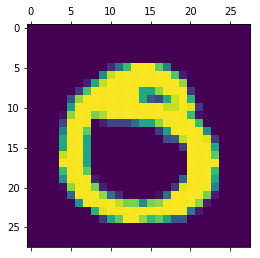

In [4]:
plt.matshow(data_labeled['image'][0, :, :])

In [5]:
slen = data_labeled['image'].shape[-1]

# Define VAE

In [6]:
latent_dim = 5
n_classes = 10

In [7]:
vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [8]:
# Load results

enc_file = "../mnist_vae_results_aws/mnist_vae_semisupervised_alpha1_enc_final"
dec_file = '../mnist_vae_results_aws/mnist_vae_semisupervised_alpha1_dec_final'

vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))

vae.eval()

HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=784, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=784, bias=True)
    (fc3): Linear(in_features=784, out_features=19, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=15, out_features=784, bias=True)
    (fc2): Linear(in_features=784, out_features=500, bias=True)
    (fc3): Linear(in_features=500, out_features=1568, bias=True)
  )
)

In [9]:
print(vae.parameters)

<bound method Module.parameters of HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=784, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=784, bias=True)
    (fc3): Linear(in_features=784, out_features=19, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=15, out_features=784, bias=True)
    (fc2): Linear(in_features=784, out_features=500, bias=True)
    (fc3): Linear(in_features=500, out_features=1568, bias=True)
  )
)>


In [10]:
loss_array = np.loadtxt('../mnist_vae_results_aws/mnist_vae_semisupervised_alpha1loss_array.txt')

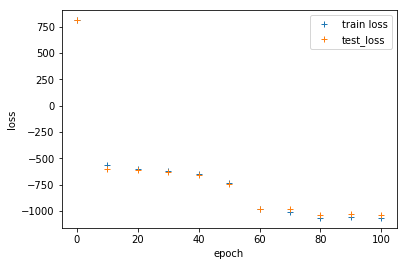

In [11]:
plt.plot(loss_array[0, :], loss_array[1, :], '+')
plt.plot(loss_array[0, :], loss_array[2, :], '+')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(('train loss', 'test_loss'))

In [12]:
vae.loss(data_unlabeled['image'])[0]

tensor(-1274.3561)

In [13]:
vae.loss(test_data['image'])[0]

tensor(-1078.6100)

In [14]:
# check a few train images

In [15]:
latent_means, latent_std, latent_samples, class_weights = \
    vae.encoder_forward(data_unlabeled['image'])

z_ind = torch.argmax(class_weights, dim = 1)
    
image_mu, image_std = vae.decoder_forward(latent_means, z_ind)

In [31]:
class_weights

tensor([[ 6.3746e-04,  3.6865e-05,  5.5576e-05,  5.2274e-04,  3.4405e-03,
          6.3427e-01,  1.5347e-06,  3.5679e-01,  1.4012e-03,  2.8452e-03],
        [ 1.0073e-04,  8.6598e-05,  2.3534e-04,  5.5371e-05,  6.8684e-05,
          9.9809e-01,  2.4458e-05,  1.2975e-06,  1.3404e-03,  1.3919e-06],
        [ 2.4414e-05,  4.2306e-05,  7.7128e-04,  8.4813e-05,  6.3223e-05,
          9.9830e-01,  3.2754e-05,  3.2140e-08,  6.8058e-04,  2.1689e-07],
        [ 4.6135e-05,  3.1199e-05,  1.2941e-03,  9.6308e-05,  5.5926e-05,
          9.9771e-01,  7.8887e-05,  2.8357e-08,  6.8969e-04,  2.9779e-07],
        [ 9.3323e-05,  6.3310e-05,  4.1825e-04,  6.8393e-05,  7.7240e-05,
          9.9814e-01,  3.7621e-05,  5.5545e-07,  1.0961e-03,  1.1635e-06],
        [ 7.4550e-06,  9.3544e-06,  1.9681e-03,  6.7180e-05,  6.6358e-05,
          9.9764e-01,  6.0340e-05,  1.8634e-09,  1.8092e-04,  6.6413e-08],
        [ 9.7453e-05,  7.7635e-05,  1.5168e-04,  5.2711e-05,  2.4861e-05,
          9.9766e-01,  1.3583e-0

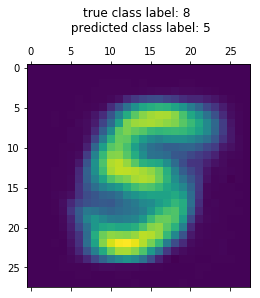

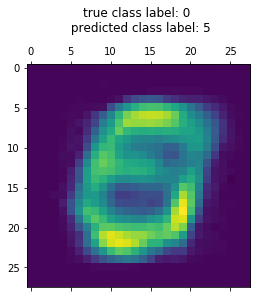

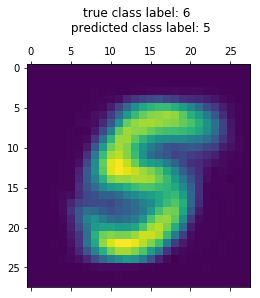

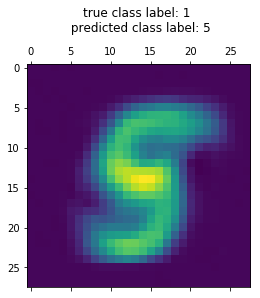

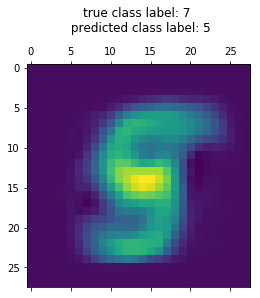

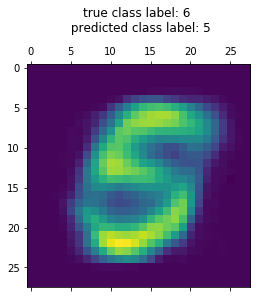

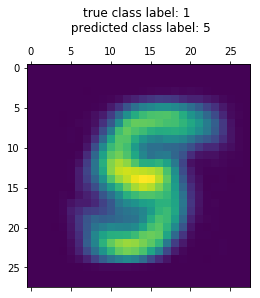

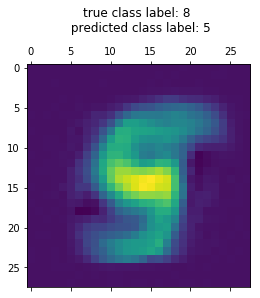

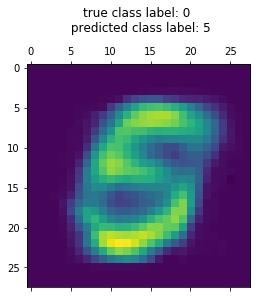

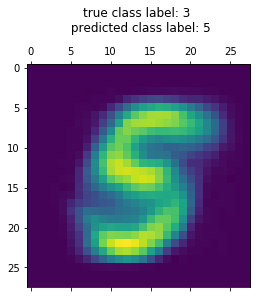

In [16]:
for i in range(10): 
    plt.matshow(image_mu[i, :, :].detach())
    plt.title('true class label: {} \n predicted class label: {}\n'.format(data_unlabeled['label'][i], z_ind[i]))

In [17]:
# check a few test images 

In [18]:
latent_means, latent_std, latent_samples, class_weights = \
    vae.encoder_forward(test_data['image'])

z_ind = torch.argmax(class_weights, dim = 1)

image_mu, image_std = vae.decoder_forward(latent_means, z_ind)

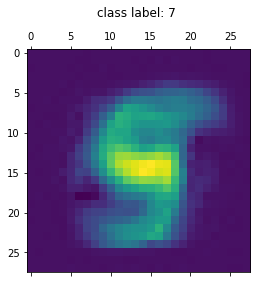

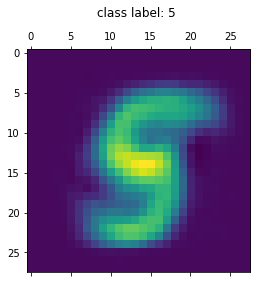

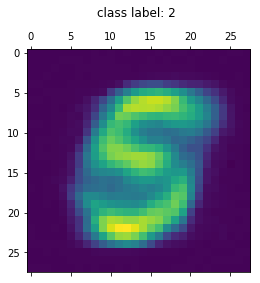

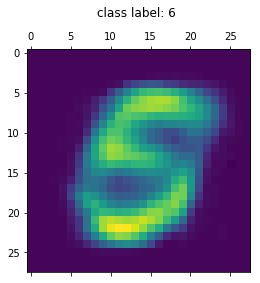

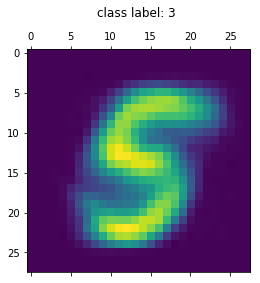

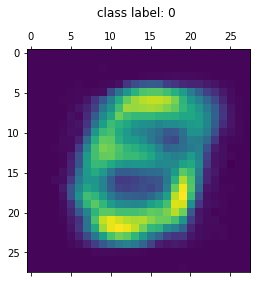

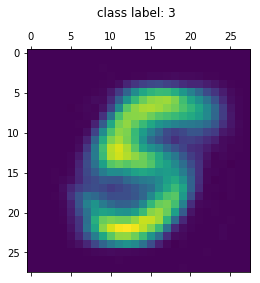

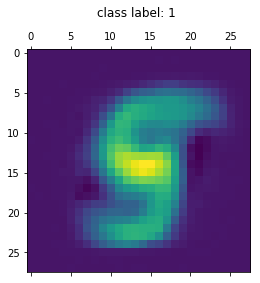

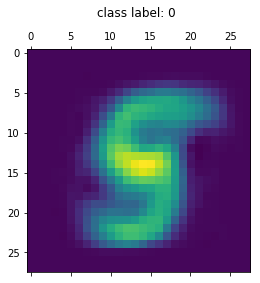

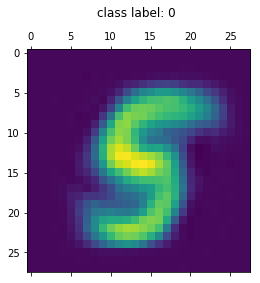

In [19]:
for i in range(10): 
    plt.matshow(image_mu[i, :, :].detach())
    plt.title('class label: {} \n'.format(test_data['label'][i]))

In [20]:
_, _, _, class_weights_unlab = \
    vae.encoder_forward(data_unlabeled['image'])

_, _, _, class_weights_lab = \
    vae.encoder_forward(data_labeled['image'])

_, _, _, class_weights_test = \
    vae.encoder_forward(test_data['image'])


In [21]:
vae.get_class_label_cross_entropy(class_weights_unlab, data_unlabeled['label']) / len(data_unlabeled['label'])

tensor(7.8305)

In [22]:
vae.get_class_label_cross_entropy(class_weights_lab, data_labeled['label']) / len(data_labeled['label'])

tensor(8.7846)

In [23]:
vae.get_class_label_cross_entropy(class_weights_test, test_data['label'])  / len(test_data['label'])

tensor(7.4573)

In [24]:
class_weights_test.shape

torch.Size([100, 10])

In [25]:
class_weights_lab.shape

torch.Size([20, 10])

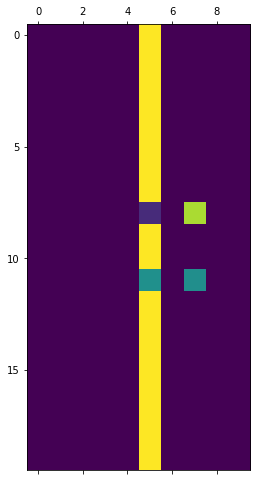

In [28]:
plt.matshow(class_weights_lab.detach())

In [30]:
common_utils.get_one_hot_encoding_from_int(test_data['label'], vae.encoder.n_classes).shape

torch.Size([100, 10])